In [1]:
%matplotlib inline

from fastai import *
from fastai.vision import *

from IPython.display import display
PATH = os.path.abspath('../..')

seed = 12345

# Load 100-epoch trained model

In [7]:
train_label_csv = f'{PATH}/catalogs/train.csv'
df = pd.read_csv(train_label_csv)

bs = 128
sz = 128

tfms = get_transforms(do_flip=True, flip_vert=True, max_rotate=15, max_zoom=1.15, p_lighting=0)

data = (ImageList.from_df(path=PATH, 
                          df=df, 
                          folder='train',
                          cols='objID',
                          suffix='.jpg')
        .split_by_rand_pct(0.2, seed=seed)
        .label_from_df(cols='oh_p50', label_cls=FloatList)
        .transform(tfms, size=sz)
        .databunch(bs=bs)
       )

learn = cnn_learner(data, base_arch=models.resnet34, pretrained=True, ps=[0.25, 0.5], loss_func=root_mean_squared_error)
learn.load('resnet34-experiment_B5');

In [11]:
df_test = pd.read_csv(f'{PATH}/catalogs/test.csv')

data.add_test(ImageList.from_df(path=PATH, 
                          df=df_test, 
                          folder='test',
                          cols='objID',
                          suffix='.jpg')
             )

In [13]:
learn.data = data

# Make predictions

Note: I need to figure out how to make test preds

In [56]:
val_preds, val_targets = learn.get_preds()

In [57]:
val_preds = val_preds.flatten()

In [59]:
val_objIDs = np.array([os.path.basename(fn)[:-4] for fn in data.valid_ds.items], dtype=np.int64)
val_objIDs

array([1237668624619929647, 1237654601031024799, 1237661357544964319, 1237661852007989339, ..., 1237667537467998394,
       1237668496849961045, 1237657630592532492, 1237666226953912621])

In [60]:
valid_df = pd.DataFrame(data={'objID': val_objIDs, 'Z_pred': val_preds})

In [61]:
master_df = pd.read_csv(f'{PATH}/catalogs/master.csv')

In [62]:
df = master_df.join(valid_df.set_index('objID'), on='objID', how='inner')

In [106]:
df.columns

Index(['objID', 'specObjID', 'ra', 'dec', 'deVAB_r', 'expAB_r', 'lnLExp_r',
       'lnLdeV_r', 'z', 'zErr', 'modelMag_u', 'modelMagErr_u', 'modelMag_g',
       'modelMagErr_g', 'modelMag_r', 'modelMagErr_r', 'modelMag_i',
       'modelMagErr_i', 'modelMag_z', 'modelMagErr_z', 'petroR50_r',
       'petroR90_r', 'nii_6584_flux', 'nii_6584_flux_err', 'h_alpha_flux',
       'h_alpha_flux_err', 'oiii_5007_flux', 'oiii_5007_flux_err',
       'h_beta_flux', 'h_beta_flux_err', 'h_delta_flux', 'h_delta_flux_err',
       'd4000', 'd4000_err', 'bptclass', 'oh_p2p5', 'oh_p16', 'oh_p50',
       'oh_p84', 'oh_p97p5', 'lgm_tot_p50', 'sfr_tot_p50', 'ab', 'Z_pred'],
      dtype='object')

In [63]:
df.sample(5)

,objID,specObjID,ra,dec,deVAB_r,expAB_r,lnLExp_r,lnLdeV_r,z,zErr,...,bptclass,oh_p2p5,oh_p16,oh_p50,oh_p84,oh_p97p5,lgm_tot_p50,sfr_tot_p50,ab,Z_pred
21569,1237655109452955724,1076525827723651072,190.836475,60.713832,0.989933,0.974106,-3.161124,-304.8947,0.153262,0.000007,...,1,9.040868,9.045675,9.057781,9.093946,9.115888,10.440220,0.925922,0.974106,9.071517
60249,1237661212047179865,1452560459277297664,224.880959,43.096111,0.772452,0.808080,-188.246600,-116.0601,0.093338,0.000010,...,1,8.803095,8.833459,8.902193,8.927771,8.973355,10.288390,0.232576,0.772452,8.958011
63434,1237661871872082037,1549242996564715520,201.914484,42.933672,0.686594,0.693818,-66.804570,-462.1432,0.065390,0.000012,...,1,8.722051,8.800797,8.851110,8.917632,8.968329,9.713636,-0.154198,0.693818,8.935329
11554,1237648722841108670,320984859923212288,179.447606,1.229514,0.343357,0.370058,-186.802400,-524.8115,0.135762,0.000010,...,1,8.860092,8.903904,8.954183,8.980352,9.016064,10.828800,0.792300,0.370058,8.990018
79285,1237662340550426696,1568508909738551296,241.945577,26.513818,0.852962,0.873558,-50.384650,-845.6349,0.092199,0.000010,...,1,8.861633,8.926670,8.978040,9.017141,9.074925,10.068660,0.077808,0.873558,9.015181


# Visualize

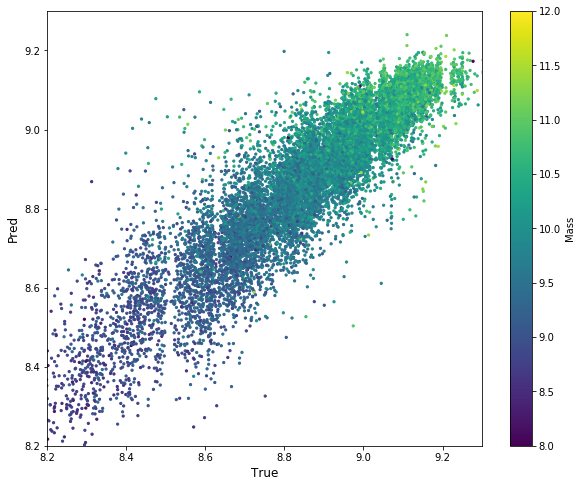

In [90]:
plt.figure(figsize=(10, 8))
plt.scatter(df.oh_p50, df.Z_pred, s=5, c=df.lgm_tot_p50, vmin=8, vmax=12)
plt.gca().set_aspect(1)

plt.xlim(8.2, 9.3)
plt.ylim(8.2, 9.3)

plt.xlabel(r'True', fontsize=12)
plt.ylabel(r'Pred', fontsize=12)
cb = plt.colorbar(label='Mass')

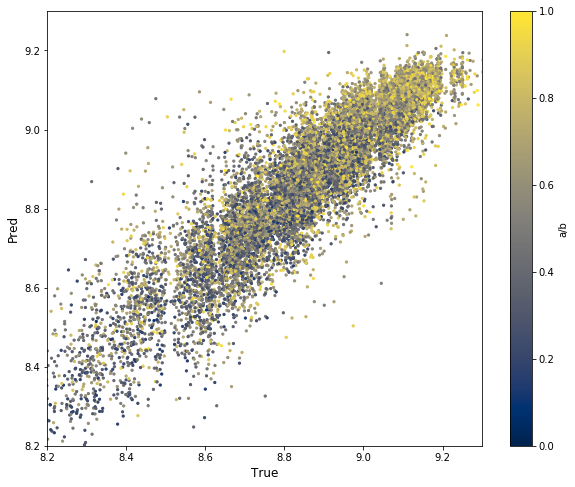

In [92]:
plt.figure(figsize=(10, 8))
plt.scatter(df.oh_p50, df.Z_pred, s=5, c=df.ab, vmin=0, vmax=1, cmap='cividis')
plt.gca().set_aspect(1)

plt.xlim(8.2, 9.3)
plt.ylim(8.2, 9.3)

plt.xlabel(r'True', fontsize=12)
plt.ylabel(r'Pred', fontsize=12)
cb = plt.colorbar(label='a/b')

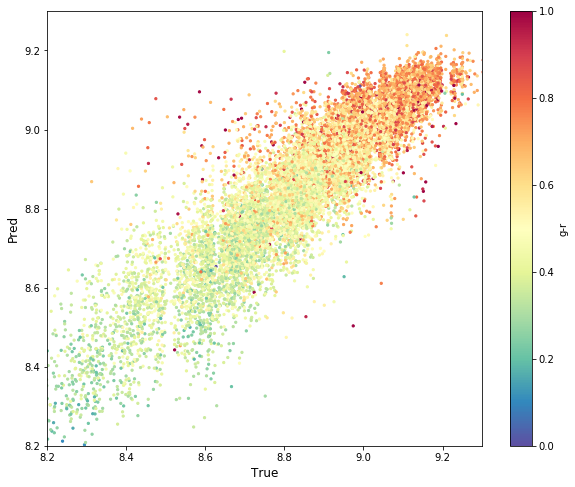

In [102]:
plt.figure(figsize=(10, 8))
plt.scatter(df.oh_p50, df.Z_pred, s=5, c=df.modelMag_g-df.modelMag_r, vmin=0, vmax=1, cmap=plt.cm.Spectral_r)
plt.gca().set_aspect(1)

plt.xlim(8.2, 9.3)
plt.ylim(8.2, 9.3)

plt.xlabel(r'True', fontsize=12)
plt.ylabel(r'Pred', fontsize=12)
cb = plt.colorbar(label='g-r')

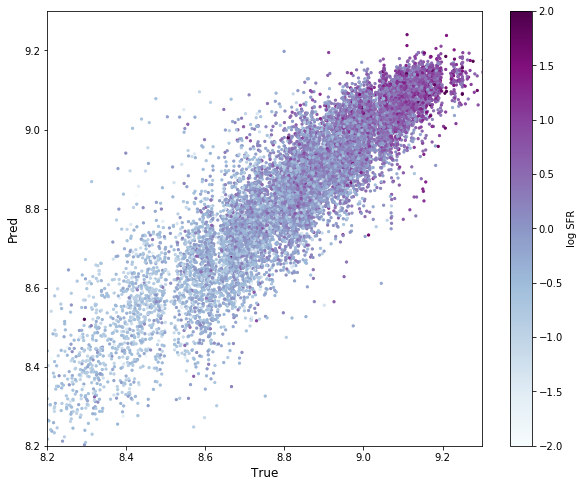

In [105]:
plt.figure(figsize=(10, 8))
plt.scatter(df.oh_p50, df.Z_pred, s=5, c=df.sfr_tot_p50, vmin=-2, vmax=2, cmap=plt.cm.BuPu)
plt.gca().set_aspect(1)

plt.xlim(8.2, 9.3)
plt.ylim(8.2, 9.3)

plt.xlabel(r'True', fontsize=12)
plt.ylabel(r'Pred', fontsize=12)
cb = plt.colorbar(label='log SFR')

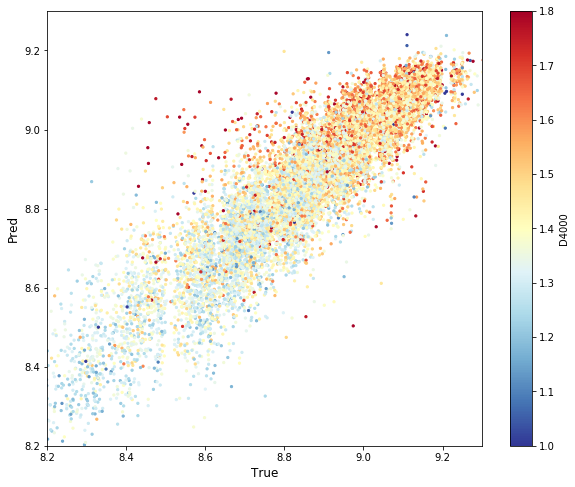

In [112]:
plt.figure(figsize=(10, 8))
plt.scatter(df.oh_p50, df.Z_pred, s=5, c=df.d4000, vmin=1, vmax=1.8, cmap=plt.cm.RdYlBu_r)
plt.gca().set_aspect(1)

plt.xlim(8.2, 9.3)
plt.ylim(8.2, 9.3)

plt.xlabel(r'True', fontsize=12)
plt.ylabel(r'Pred', fontsize=12)
cb = plt.colorbar(label='D4000')

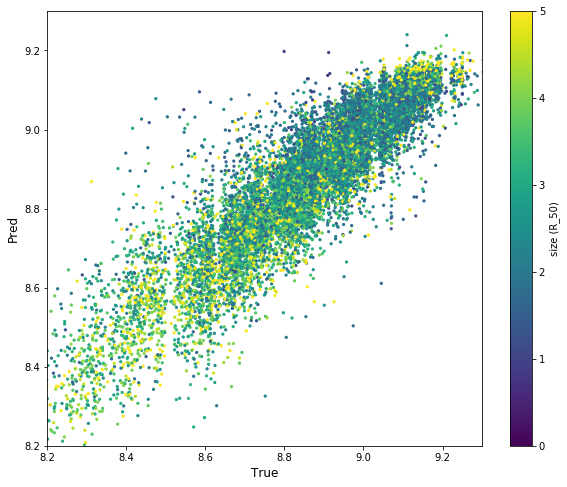

In [114]:
plt.figure(figsize=(10, 8))
plt.scatter(df.oh_p50, df.Z_pred, s=5, c=df.petroR50_r, vmin=0, vmax=5, cmap=plt.cm.viridis)
plt.gca().set_aspect(1)

plt.xlim(8.2, 9.3)
plt.ylim(8.2, 9.3)

plt.xlabel(r'True', fontsize=12)
plt.ylabel(r'Pred', fontsize=12)
cb = plt.colorbar(label='size (R_50)')

# Examining delta Z

In [115]:
df['deltaZ'] = df.Z_pred - df.oh_p50

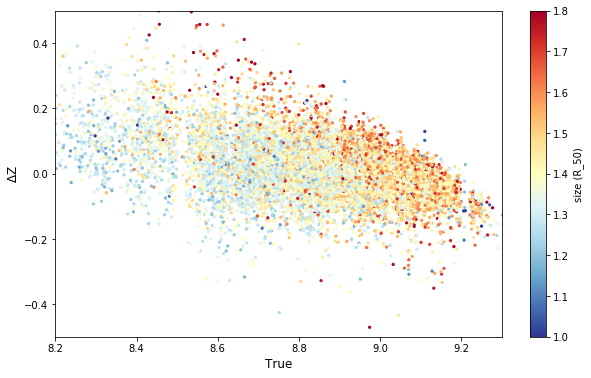

In [120]:
plt.figure(figsize=(10, 6))

plt.scatter(df.oh_p50, df.deltaZ, s=5, c=df.d4000, vmin=1, vmax=1.8, cmap=plt.cm.RdYlBu_r)
plt.xlim(8.2, 9.3)
plt.ylim(-0.5, 0.5)

plt.xlabel(r'True', fontsize=12)
plt.ylabel(r'$\Delta$Z', fontsize=12)

cb = plt.colorbar(label='size (R_50)')

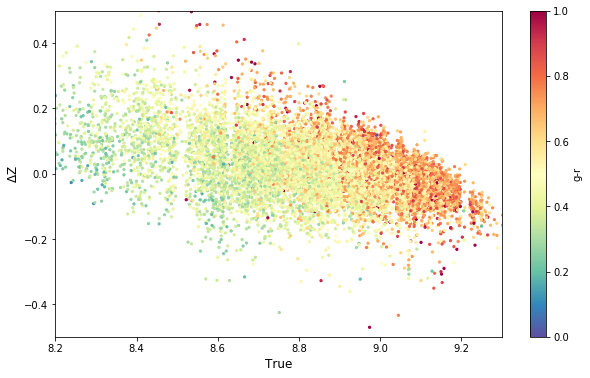

In [125]:
plt.figure(figsize=(10, 6))

plt.scatter(df.oh_p50, df.deltaZ, s=5, c=df.modelMag_g-df.modelMag_r, vmin=0, vmax=1, cmap=plt.cm.Spectral_r)
plt.xlim(8.2, 9.3)
plt.ylim(-0.5, 0.5)

plt.xlabel(r'True', fontsize=12)
plt.ylabel(r'$\Delta$Z', fontsize=12)

cb = plt.colorbar(label='g-r')

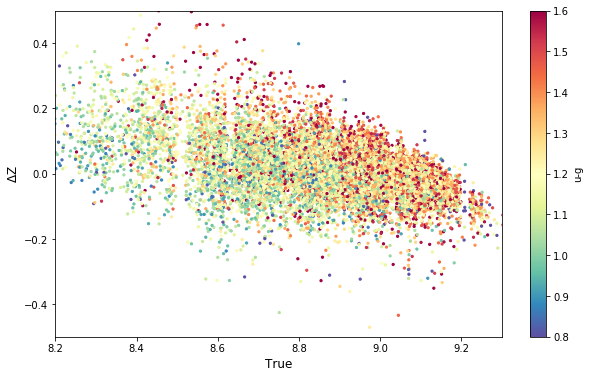

In [127]:
plt.figure(figsize=(10, 6))

plt.scatter(df.oh_p50, df.deltaZ, s=5, c=df.modelMag_u-df.modelMag_g, vmin=0.8, vmax=1.6, cmap=plt.cm.Spectral_r)
plt.xlim(8.2, 9.3)
plt.ylim(-0.5, 0.5)

plt.xlabel(r'True', fontsize=12)
plt.ylabel(r'$\Delta$Z', fontsize=12)

cb = plt.colorbar(label='u-g')

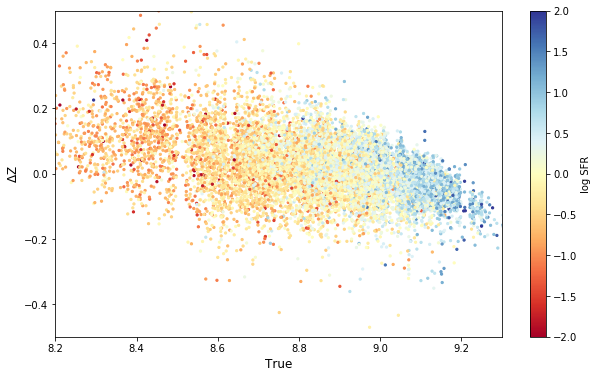

In [128]:
plt.figure(figsize=(10, 6))

plt.scatter(df.oh_p50, df.deltaZ, s=5, c=df.sfr_tot_p50, vmin=-2, vmax=2, cmap=plt.cm.RdYlBu)
plt.xlim(8.2, 9.3)
plt.ylim(-0.5, 0.5)

plt.xlabel(r'True', fontsize=12)
plt.ylabel(r'$\Delta$Z', fontsize=12)

cb = plt.colorbar(label='log SFR')

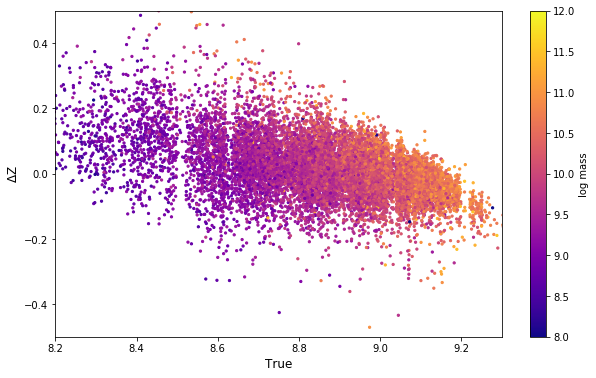

In [130]:
plt.figure(figsize=(10, 6))

plt.scatter(df.oh_p50, df.deltaZ, s=5, c=df.lgm_tot_p50, vmin=8, vmax=12, cmap=plt.cm.plasma)
plt.xlim(8.2, 9.3)
plt.ylim(-0.5, 0.5)

plt.xlabel(r'True', fontsize=12)
plt.ylabel(r'$\Delta$Z', fontsize=12)

cb = plt.colorbar(label='log mass')